# Miguel Angel Paz Camacho

# Hackaton Mentes Bayesianas

In [1]:
import os
import re
from keras.preprocessing.text import Tokenizer

#Funcion donde especificamos la ruta de los archivos y nos devuelve el contenido
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []

    with open(path_corpus, "r", encoding="utf-8") as f_corpus, open(path_truth, "r", encoding="utf-8") as f_truth:
        for twitt in f_corpus:
            tr_txt += [twitt]
        for label in f_truth:
            tr_y += [label]
    
    return tr_txt, tr_y

In [2]:
import pandas as pd
tr_txt = pd.read_csv('claudia.csv', header=None, sep="\n\n")[0].tolist()#, tr_y = get_texts_from_file("mex20_train.txt","mex20_train_labels.txt")

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14564\3059379985.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tr_txt = pd.read_csv('claudia.csv', header=None, sep="\n\n")[0].tolist()#, tr_y = get_texts_from_file("mex20_train.txt","mex20_train_labels.txt")


In [3]:
print(tr_txt)

['qué tal muy buenas noches', 'buenas noches a todos', 'muy buena pregunta', 'antes que nada quisiera felicitar al cuerpo diplomático de méxico en ecuador que acaba de regresar felicitarlo por su valentía', 'también quiero poner en contexto antes de preguntar la pregunta que en este debate se van a presentar principalmente dos proyectos el proyecto de regresar al pasado de la corrupción y el proyecto que significa avanzar con la transformación', 'ahora sí vamos a responder la pregunta', 'esencialmente se trata de fortalecer el sistema de salud pública en la constitución está establecido en el cuarto constitucional el sistema nacional de salud pública para el bienestar que está constituido por el imss por el issste y por el imssbienestar', 'nuestro proyecto es fortalecerlo desde la prevención hasta la tensión más compleja de cualquier enfermedad de la salud y los medicamentos gratuitos tenemos el presupuesto para poderlo hacer', 'sí por supuesto que hay que ir invirtiendo cada vez más',

In [4]:
#val_txt, val_y = get_texts_from_file("mex20_val.txt","mex20_val_labels.txt")

In [5]:
import nltk
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [6]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc)

fdist = nltk.FreqDist(corpus_palabras)

In [7]:
def SortFreqDict(freqdict):
    aux = [(freqdict[key],key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [8]:
V = SortFreqDict(fdist)
V = V[:5000]
print(len(V))

1007


In [9]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont +=1

 BoW

In [10]:
import numpy as np

def build_bow_tr(tr_txt, V, dict_indices):
    BOW = np.zeros((len(tr_txt), len(V)), dtype=int)
    
    cont_doc =0 
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = 1
        cont_doc +=1
    
    return BOW

In [11]:
BOW_tr = build_bow_tr(tr_txt, V, dict_indices)

# 1 TCOR

## Programación

In [12]:
import math

def compute_tcor(docs, dict_indices):

    len_V = len(dict_indices)

    DTR = np.zeros((len_V, len_V), dtype=float)
    print("TCOR: Shape of the term-term matrix:",DTR.shape)

    tam_V = len_V

    CO = np.zeros((len_V, len_V), dtype=float)

    #Construccion de matriz de co-ocurrencia
    for doc, i in zip(docs, range(len(docs))):
        doc_tok = tokenizer.tokenize(doc)
        for w1 in doc_tok:
            if w1 in dict_indices:
                for w2 in doc_tok:
                    if w1 != w2:
                        if w2 in dict_indices:
                            CO[dict_indices[w1],dict_indices[w2]] +=1


    #Matriz de co-ocurrencia completada

    print("LLenando Matriz")

    for i in range(tam_V):
        if(i%1000==0):
            print(i)
        no_ceros_i = np.nonzero(CO[:, i])[0]
        for j in no_ceros_i:
            if i == j:
                print("nooo")
            tff = CO[i,j]
            tk = len(no_ceros_i)
            DTR[i, j] = (1+math.log10(np.where(tff>0,tff,1))) * math.log10(np.where(tk>0,tam_V/tk,1))
    
    return DTR

In [13]:
from sklearn import preprocessing

TCOR_base = compute_tcor(tr_txt, dict_indices)

TCOR_base = preprocessing.normalize(TCOR_base, norm='l2')

TCOR: Shape of the term-term matrix: (1007, 1007)
LLenando Matriz
0
1000


In [14]:
TCOR_base

array([[0.        , 0.0732237 , 0.07406886, ..., 0.02632323, 0.03241385,
        0.03597664],
       [0.07525627, 0.        , 0.07390028, ..., 0.        , 0.02079423,
        0.02079423],
       [0.078752  , 0.07645061, 0.        , ..., 0.02151185, 0.03177562,
        0.03446328],
       ...,
       [0.3244672 , 0.        , 0.24939256, ..., 0.        , 0.        ,
        0.        ],
       [0.26651503, 0.16635771, 0.24573051, ..., 0.        , 0.        ,
        0.        ],
       [0.28227816, 0.15874812, 0.254324  , ..., 0.        , 0.        ,
        0.        ]])

In [15]:
from sklearn.feature_selection import SelectKBest, chi2

feats = SelectKBest(chi2, k=1000)
#feats.fit(BOW_tr, tr_y)

In [16]:
#best = feats.get_support(indices = True)

In [17]:
#best

In [18]:
dict_indice_invertido = {}
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w

In [24]:
#from tsne import tsne
#reduced_matrix = tsne(target_matrix, 2)

from sklearn.manifold import TSNE
tsne_2 = TSNE(n_components=2)
reduced_matrix = tsne_2.fit_transform(TCOR_base)



c:\Users\Miguel\anaconda3\envs\machine-learning\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Miguel\anaconda3\envs\machine-learning\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [25]:
reduced_matrix.shape

(1007, 2)

In [26]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

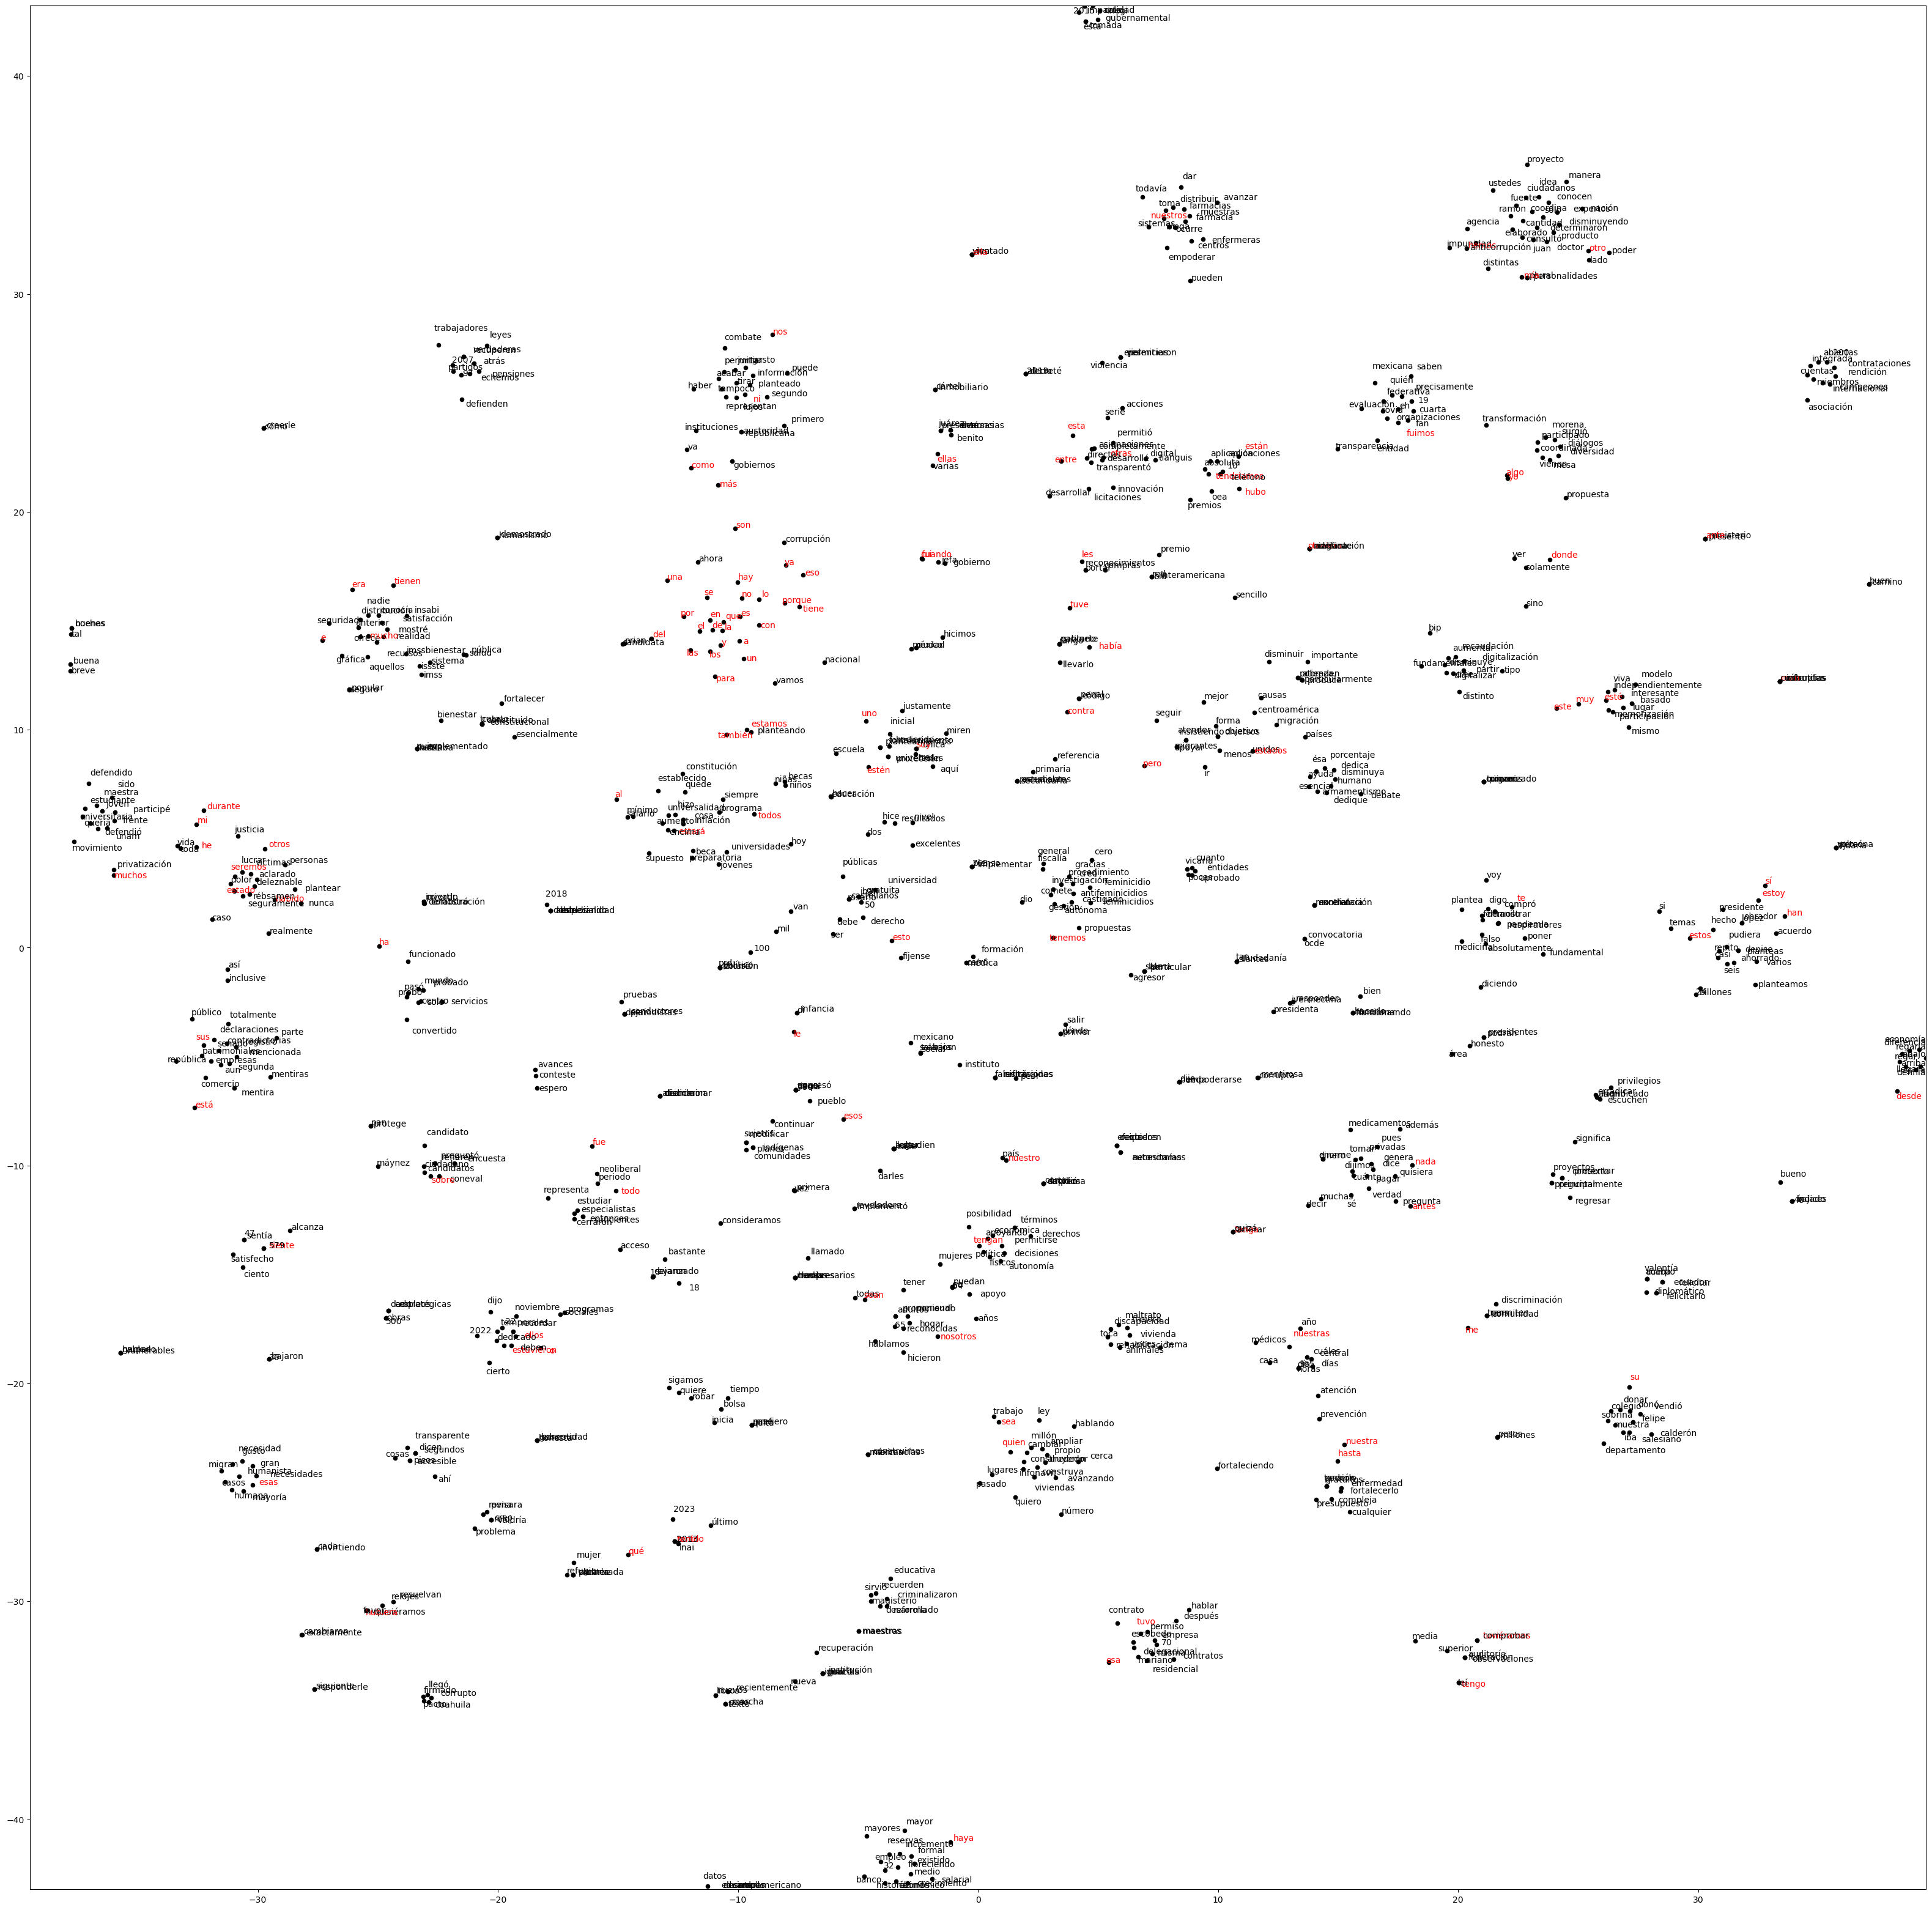

In [37]:
import matplotlib.pyplot as plt
import adjustText
#%matplotlib inline

from nltk.corpus import stopwords

sw = set(stopwords.words("spanish"))

plt.figure(figsize=(40,40), dpi=100); plt.xlim((-max_x, max_x)); plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color="black");

labels = []
for idx, word in enumerate(V[:]):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]

    _,word = word

    if word in sw:
        labels.append(plt.text(x, y, word, color = 'red') )
    else:
        labels.append(plt.text(x, y, word, color = 'black') )

#label = np.array(V)[:,1]
#print(label)
adjustText.adjust_text(labels)
plt.show()

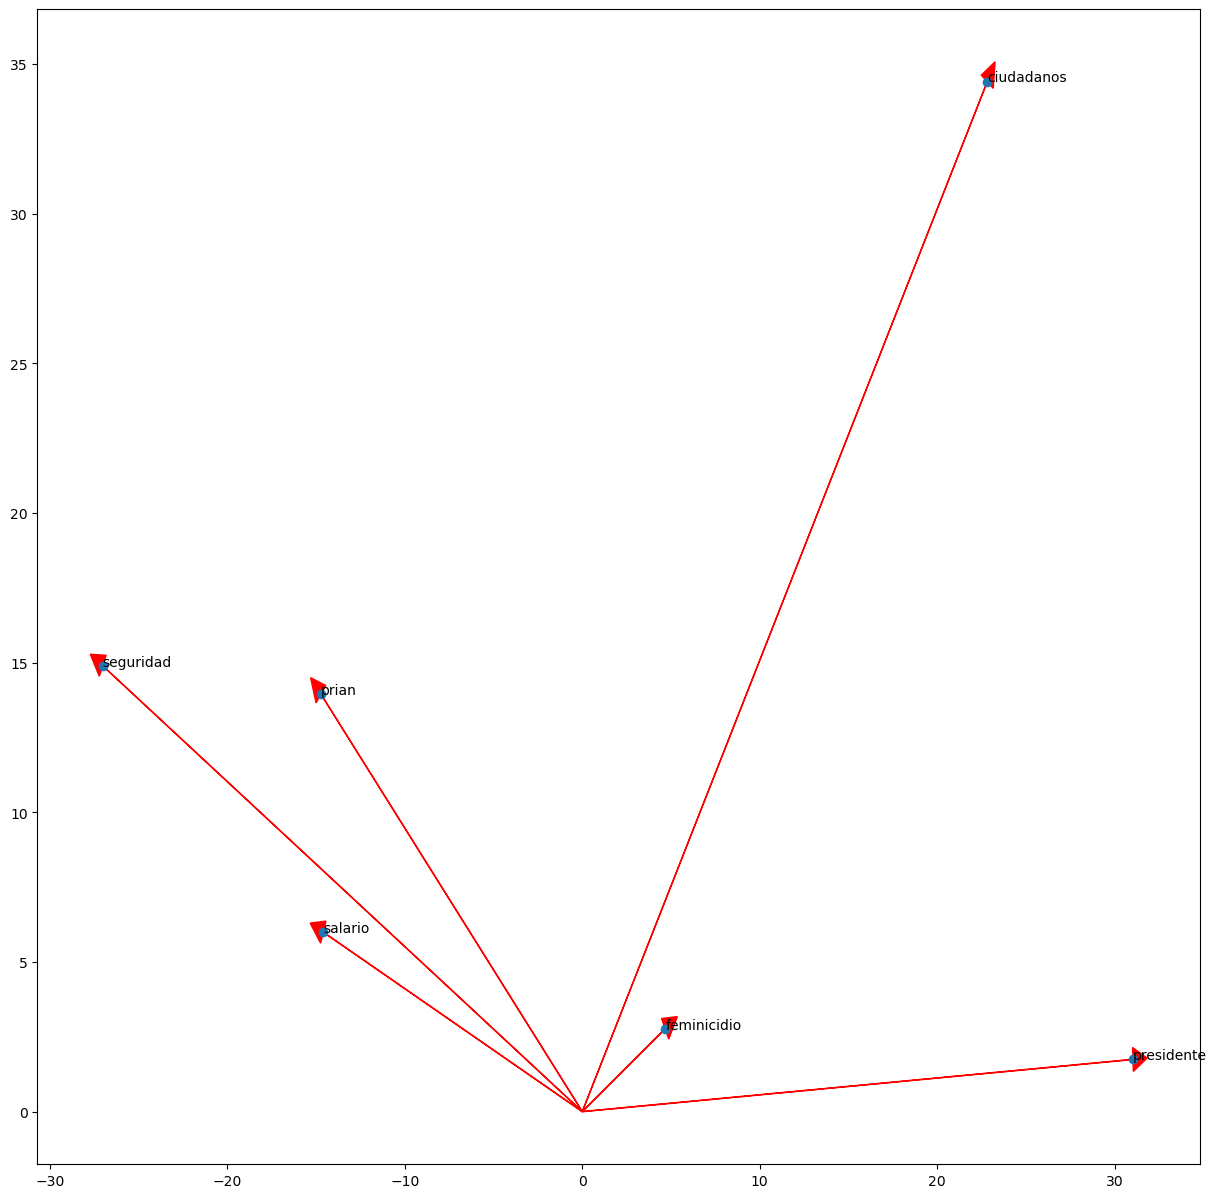

In [39]:
subsetwords = ["presidente", "feminicidio", "seguridad", "ciudadanos", "salario", "prian"]

ploted_subsetwords = []
subreduced_matrix = []
for idx, word in enumerate(V[:]):
    _,word = word
    if word in subsetwords:
        ploted_subsetwords += [word]
        subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)

fig, ax = plt.subplots(figsize = (15,15))

col1 = 0
col2 = 1

for word in subreduced_matrix:
    ax.arrow(0,0, word[col1], word[col2], head_width=0.8, head_length=0.8, fc='r', ec='r', width = 1e-2)

ax.scatter(subreduced_matrix[:,col1], subreduced_matrix[:,col2])

for i in range(0, len(ploted_subsetwords)):
    ax.annotate(ploted_subsetwords[i], (subreduced_matrix[i,col1], subreduced_matrix[i,col2]))
